In [ ]:
import os
import sys
sys.path.append('drive/MyDrive/HKUST/Comp 4641 Project')

In [ ]:
import matplotlib.pyplot as plt

# Build network

In [ ]:
import pandas as pd
from collections import defaultdict
import networkx as nx
from itertools import chain
import numpy as np
import random

In [ ]:
def load_data(file_name):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for user_id, friends in zip(df["user_id"], df["friends"]):
        friends = eval(friends)
        for friend in friends:
            # add each friend relation as an edge
            edges.append((user_id, friend))
    edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    true_edges = set(true_edges)
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        head, tail = np.random.choice(nodes, 2)
        if head != tail and (head, tail) not in true_edges and (head, tail) not in false_edges:
            false_edges.add((head, tail))    
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edges = sorted(edges)
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.Graph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

In [ ]:
whole_graph = nx.readwrite.gexf.read_gexf("drive/MyDrive/HKUST/Comp 4641 Project/hashtag_count/retweet_network_v1.1.gexf")
#whole_graph = construct_graph_from_edges(whole_graph.edges)

In [ ]:
type(whole_graph), whole_graph.number_of_edges(), whole_graph.number_of_nodes()

(networkx.classes.graph.Graph, 1645, 1940)

In [ ]:
# Take a random sample of edges
valid_edges = random.sample(whole_graph.edges(), int(0.25 * whole_graph.number_of_edges()))
# Remove some edges
train_graph = whole_graph.copy()
train_graph.remove_edges_from(valid_edges)

In [ ]:
print("number of nodes: ", train_graph.number_of_nodes())
print("number of edges: ", train_graph.number_of_edges())

number of nodes:  1940
number of edges:  1234


In [ ]:
valid_graph = construct_graph_from_edges(valid_edges)

number of nodes: 540
number of edges: 411


In [ ]:
valid_keys = set(valid_graph.nodes.keys())
valid_keys.intersection_update(set(train_graph.nodes.keys()))
valid_graph = valid_graph.subgraph(valid_keys)
valid_graph.number_of_nodes(), valid_graph.number_of_edges()

(540, 411)

In [ ]:
false_edges =  generate_false_edges(whole_graph.edges, num_false_edges=int(0.25 * whole_graph.number_of_edges()))

In [ ]:
from node2vec import Deepwalk, node2vec

In [ ]:
n2v = node2vec(train_graph, p=5, node_dim=2)
n2v()
n2v.evaluate(valid_edges, false_edges)

building a node2vec model...	number of walks: 19400	average walk length: 7.9541	trainig time: 4.3620


0.3341828428673759

In [ ]:
train_embedding = [n2v.get_embedding(node) for node in train_graph.nodes]
valid_embedding = [n2v.get_embedding(node) for node in valid_graph.nodes]

In [ ]:
train_embedding = np.vstack(train_embedding)
valid_embedding = np.vstack(valid_embedding)

In [ ]:
train_embedding.shape

(1940, 2)

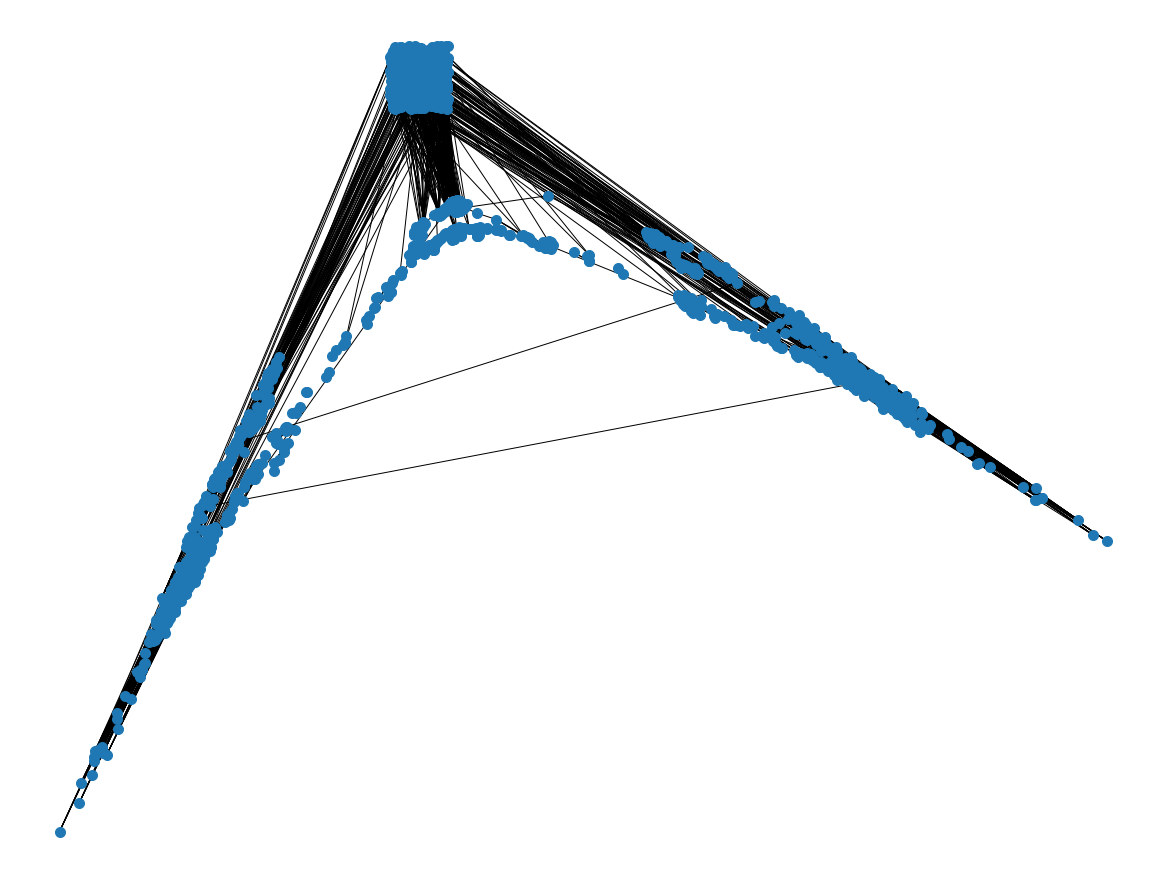

In [ ]:
nodes_pos = dict(zip(whole_graph.nodes, train_embedding))

plt.figure(figsize = (16, 12))
nx.draw(whole_graph, nodes_pos, node_size=100)
plt.draw()

In [ ]:
n2v = node2vec(train_graph, p=5)
n2v()
n2v.evaluate(valid_edges, false_edges)

building a node2vec model...	number of walks: 19400	average walk length: 7.9541	trainig time: 4.4540


0.2815990906992026

In [ ]:
train_embedding = [n2v.get_embedding(node) for node in train_graph.nodes]
valid_embedding = [n2v.get_embedding(node) for node in valid_graph.nodes]

In [ ]:
train_embedding = np.vstack(train_embedding)
valid_embedding = np.vstack(valid_embedding)

# UMAP

In [ ]:
!pip install -q umap-learn

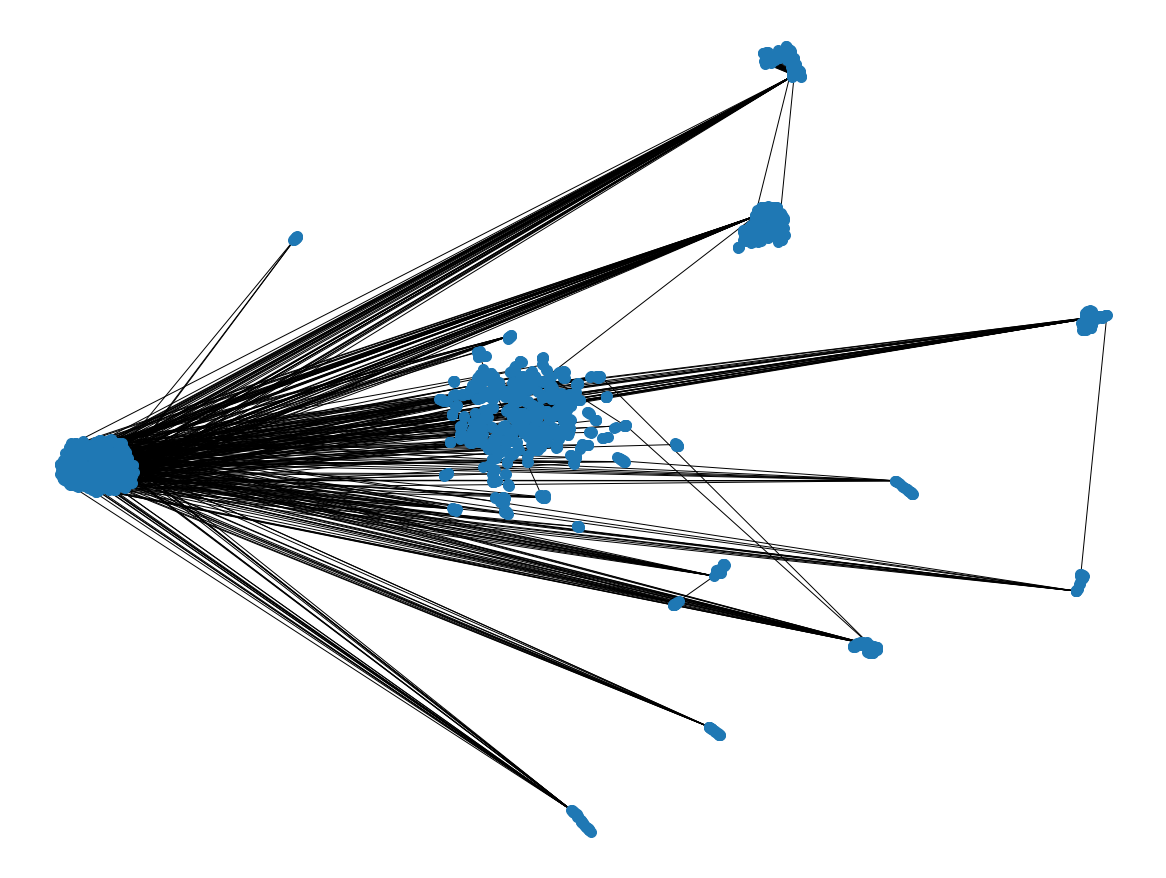

In [ ]:
import umap
reducer = umap.UMAP()
train_reduced = reducer.fit_transform(train_embedding)
nodes_pos = dict(zip(train_graph.nodes, train_reduced))

plt.figure(figsize = (16, 12))
nx.draw(whole_graph, nodes_pos, node_size=100)
plt.draw()

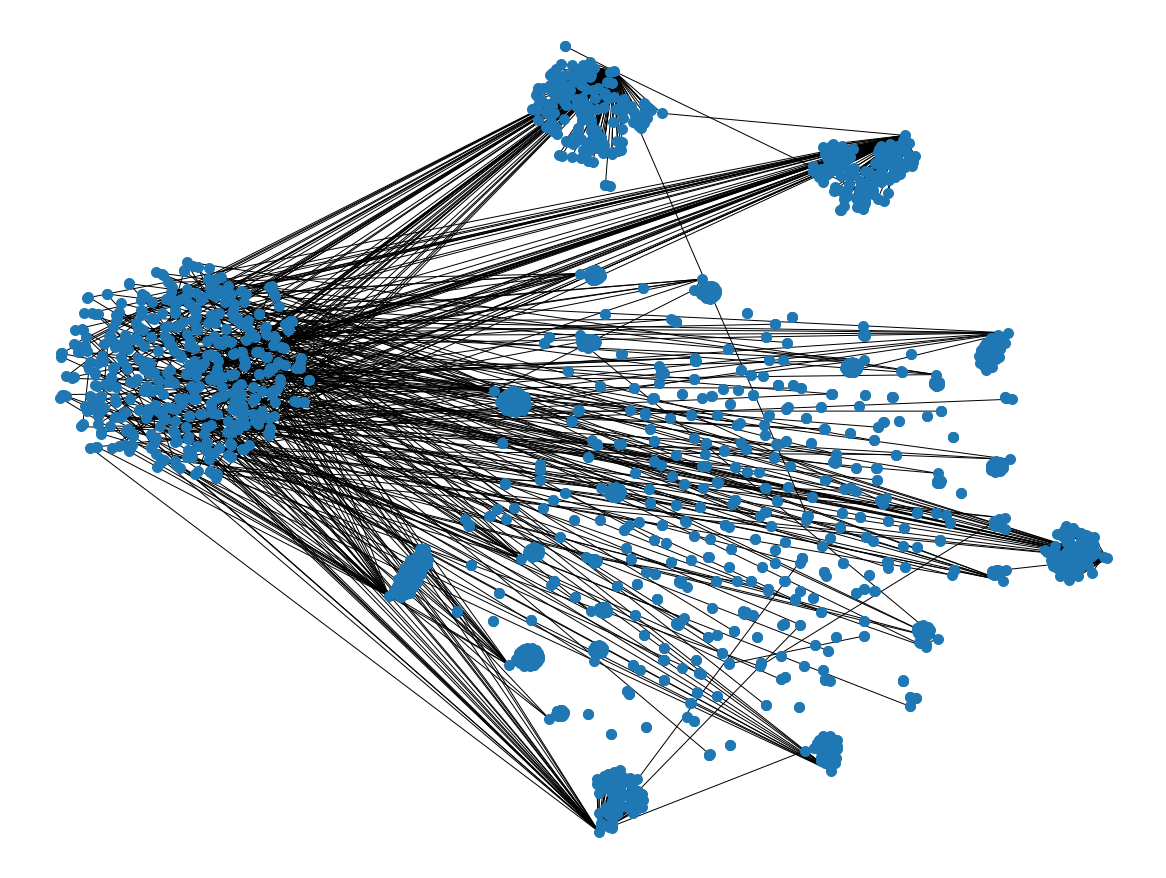

In [ ]:
from sklearn.manifold import TSNE
reducer = TSNE()
train_reduced = reducer.fit_transform(train_embedding)
nodes_pos = dict(zip(train_graph.nodes, train_reduced))

plt.figure(figsize = (16, 12))
nx.draw(whole_graph, nodes_pos, node_size=100)
plt.draw()

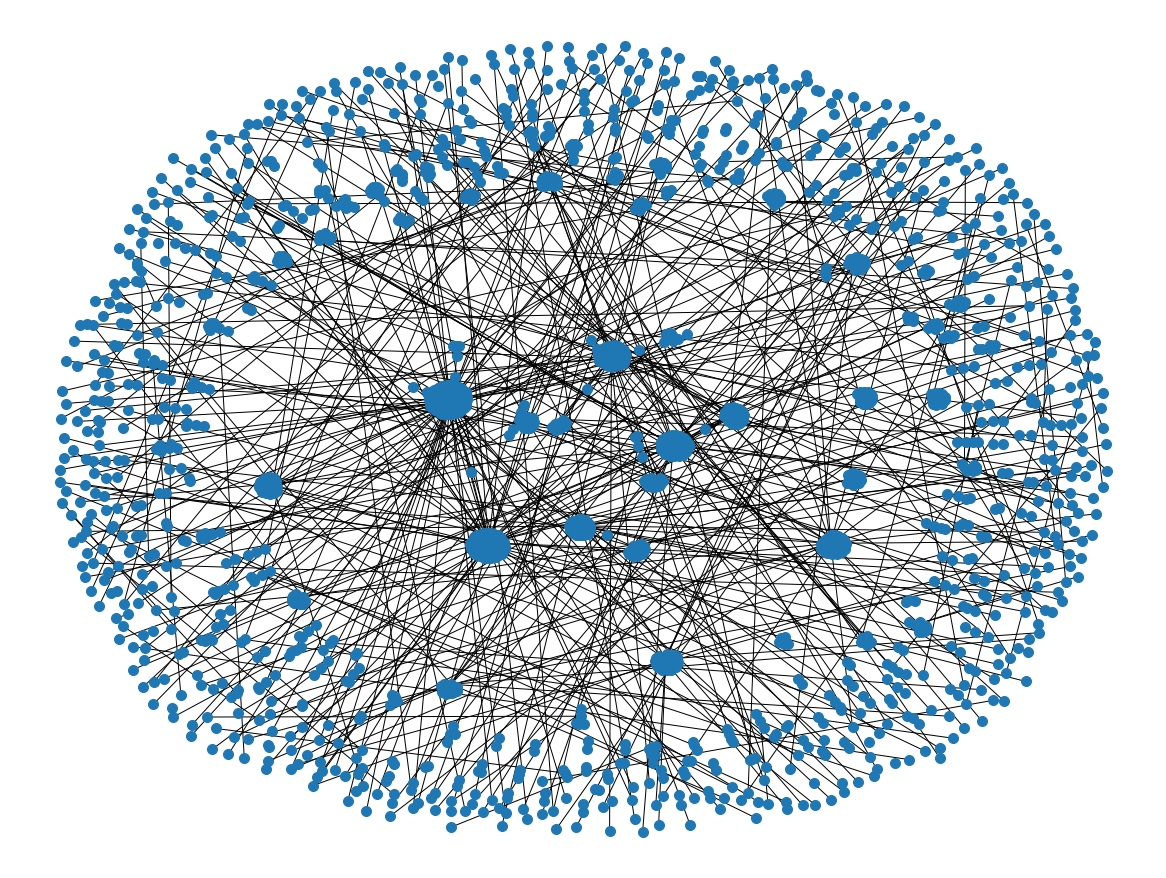

In [ ]:
nodes_pos = nx.fruchterman_reingold_layout(train_graph)

plt.figure(figsize = (16, 12))
nx.draw(whole_graph, nodes_pos, node_size=100)
plt.draw()